In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import json
import sys
sys.path.append("../../")


from src.dataset_manager import DatasetConvertor 
from src.context_free.config import ModelConfig, TrainingConfig, DatasetConfig
from src.context_free.preprocessing import PreparingDataset
from src.context_free.models import createModel
from src.context_free.training import trainModel
from src.context_free.evaluation import evaluateModel

In [2]:
direction = "forward"
lenWindow = 20
lenSource = 10
verbose = True

rawDatasetFolder = "../../data/raw"
model_folder = "../../data/models/context_free"
configPath = "../config/conbined_flows.json"

========== Combined ============
Forward: Compression rate: 0.2328
Size of train loader: 8, Size of test loader: 6
Size of model: 1324289
Seq2Seq(
  (encoder): Encoder(
    (lstm_layers): ModuleList(
      (0): LSTM(1, 128, bidirectional=True)
      (1): LSTM(256, 128, bidirectional=True)
    )
    (ln_layers): ModuleList(
      (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): Identity()
    )
  )
  (decoder): Decoder(
    (lstm_layers): ModuleList(
      (0): LSTM(1, 256)
      (1): LSTM(256, 256)
    )
    (ln_layers): ModuleList(
      (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): Identity()
    )
    (fc_out): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoch [1/10], Train Loss: 21.116778, Validation 

c:\Users\Ye\Documents\YuYeh_Documents\L2S\Projects\context_aware_traffic_predictor\experiments\notebooks\../..\src\base\base_model.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

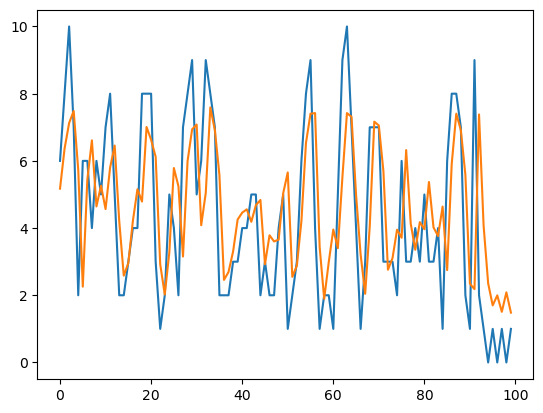

In [4]:
config = json.load(open(configPath, "r"))
mapping = config.get("DIRECTION_MAPPING", {})
dpdr_params = config.get("dpdr_params", {})

datasetConverter = DatasetConvertor(rawDatasetFolder, config)
datasetConverter.processDataset(direction=direction, **dpdr_params[direction])
thumbDataUnit = datasetConverter.getDataUnit(f"combined_{mapping[direction]}")

datasetConfig = DatasetConfig.initialize(len_window=lenWindow, len_source=lenSource, data_augment=True)
trainData, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)

# Match model dims to dataset feature sizes
modelConfig = ModelConfig()
model, device = createModel(modelConfig)

# Reduce training load to avoid OOM/errors
trainingConfig = TrainingConfig()
model, avg_train_loss_history, avg_test_loss_history = trainModel(
    model, trainData, testData, trainingConfig, verbose=verbose
)
model.save_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{lenWindow}.pth")

datasetConfig = DatasetConfig.initialize(
    len_window=lenWindow, len_source=lenSource, data_augment=False)
model, device = createModel(modelConfig)
model.load_checkpoint(f"{model_folder}/direction_{direction}_lenWindow_{lenWindow}.pth")
_, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)
actual, predicted = evaluateModel(model, testData)

plt.plot(actual[0:100])
plt.plot(predicted[0:100])
plt.show()